<br>

<br>

# Import required packages and libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torchvision import datasets
from torch import nn, optim, autograd
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from numpy import save


# Download MNIST data

In [2]:
# Download MNIST data
train_dataset = datasets.MNIST('~/datasets/mnist', train=True, download=True)
test_dataset = datasets.MNIST('~/datasets/mnist', train=False, download=True)

# Extract images and their labels
X_train = train_dataset.data
y_train = np.array(train_dataset.targets)
X_test = test_dataset.data
y_test = np.array(test_dataset.targets)

# Useful functions

In [3]:
def binarize(y, label_noise=0.):
    y = np.copy(y) > 4
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None):    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)  
    colored_X = colored_X.numpy()
    return (colored_X.astype(float)/ 255.), color.astype(int)


# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True):    
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0   
    colored_X = colored_X.reshape(X.shape[0],-1) 
    colored_X = colored_X.numpy()
    return (colored_X.astype(float)/ 255.)

# resize original images
def resize_og_images(X):    
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)   
    colored_X = colored_X.reshape(X.shape[0],-1) 
    colored_X = colored_X.numpy()
    return (colored_X.astype(float)/ 255.)

    
# Used to plot images    
def plot_images(X, n_row=5, n_col=5, shape=(2,28,28), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

# # Used to plot images    
# def plot_images(X, n_row=5, n_col=5, shape=(2,14,14), scale=False):
#     fig = plt.figure(figsize=(n_row, n_col))
#     grid = ImageGrid(fig, 111,  
#                      nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
#                      axes_pad=0.05,  # pad between axes in inch.
#                      )
#     for ax in grid:
#         index = np.random.choice(np.arange(X.shape[0]))
#         img = X[index].reshape(shape)
#         if scale:
#             img = img - img.min()
#             img /= img.max()
#         img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
#         img = np.moveaxis(img, 0, -1)
#         ax.imshow(img)
#         ax.set_axis_off()
#     plt.show()
#     return

<br>

# Define, train, and evaluate the feature extractor

Example images used to train the feature extractor randomly colored green and red


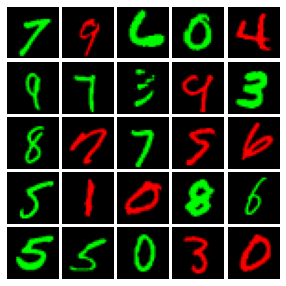

Feature extractor architecture definition:
Sequential(
  (0): Linear(in_features=1568, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)

Training the feature extractor...

Feature extractor evaluation:
Label Accuracy:  0.9613
Color Accuracy:  1.0


In [4]:
# Define the feature extractor

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print("Feature extractor architecture definition:")
        print(self.net)

    def forward(self, x):
        return self.net(x)

    
# Prepare data to use for training the feature extractor

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise)
X_test, color_test = color_digits(X_test, y_test, color_noise)

print("Example images used to train the feature extractor randomly colored green and red")
plot_images(X_train)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# hidden_size = [2*14*14, 50, 2]
hidden_size = [2*28*28, 50, 2]
net = MLP(hidden_size).to(device)

# Train the feature extractor  
print()
print("Training the feature extractor...")

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
      
        
# Evaluate the feature extractor
print()
print("Feature extractor evaluation:")
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract image features 

In [5]:

class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        # print("Print all the trained model layers")
        # print(self.children_list)
        self.children_list = self.children_list[0][:2]
        # print("Print model layers after dropping the output layer for feature extraction")    
        # print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x, device = 'cpu'):
    extracted_features = []
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features = extracted_features.numpy()
    print("Z features shape", extracted_features.shape)
    return extracted_features


Original images


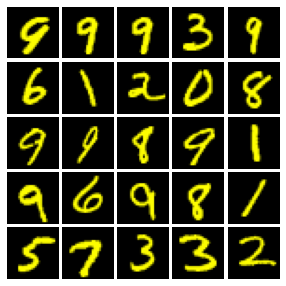

Images colored green


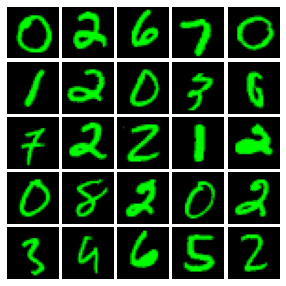

In [6]:
# prepare train and test labels for saving as numpy files
train_labels_mnist = np.array(train_dataset.targets)
test_labels_mnist = np.array(test_dataset.targets)

# Prepare images from which features will be extracted (resized original and green images)

X_train_og_mnist_mlp = resize_og_images(train_dataset.data) 
X_train_green_mnist_mlp = color_all_images_same_color(train_dataset.data, green=True)

X_test_og_mnist_mlp = resize_og_images(test_dataset.data) 
X_test_green_mnist_mlp = color_all_images_same_color(test_dataset.data, green=True)

print("Original images")
plot_images(X_test_og_mnist_mlp)

print("Images colored green")
plot_images(X_test_green_mnist_mlp)


In [7]:
# create the feature extractor object
feature_extractor = feature_extractor()

# Extract image features from resized original and green images
print("### Extracting features using MLP trained on MNIST ###") 
Z_train_og_mnist_mlp = extract_features(feature_extractor,torch.from_numpy(X_train_og_mnist_mlp))
Z_train_green_mnist_mlp = extract_features(feature_extractor,torch.from_numpy(X_train_green_mnist_mlp))

Z_test_og_mnist_mlp = extract_features(feature_extractor,torch.from_numpy(X_test_og_mnist_mlp))
Z_test_green_mnist_mlp = extract_features(feature_extractor,torch.from_numpy(X_test_green_mnist_mlp))


### Extracting features using MLP trained on MNIST ###
Z features shape (60000, 50)
Z features shape (60000, 50)
Z features shape (10000, 50)
Z features shape (10000, 50)


In [8]:
# Save extracted features and image labels as numpy files
save('../data/Z_train_og_mnist_mlp.npy', Z_train_og_mnist_mlp)
save('../data/Z_train_green_mnist_mlp.npy', Z_train_green_mnist_mlp)

save('../data/Z_test_og_mnist_mlp.npy', Z_test_og_mnist_mlp)
save('../data/Z_test_green_mnist_mlp.npy', Z_test_green_mnist_mlp)

save('../data/train_labels_mnist.npy', train_labels_mnist)
save('../data/test_labels_mnist.npy', test_labels_mnist)
